T params: 9901587
D params: 13494209


libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
/cache/selikhanovych/KernelNeuralOptimalTransport/notebooks/../src/cunet.py:62: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
/cache/selikhanovych/KernelNeuralOptimalTransport/notebooks/../src/cunet.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep th

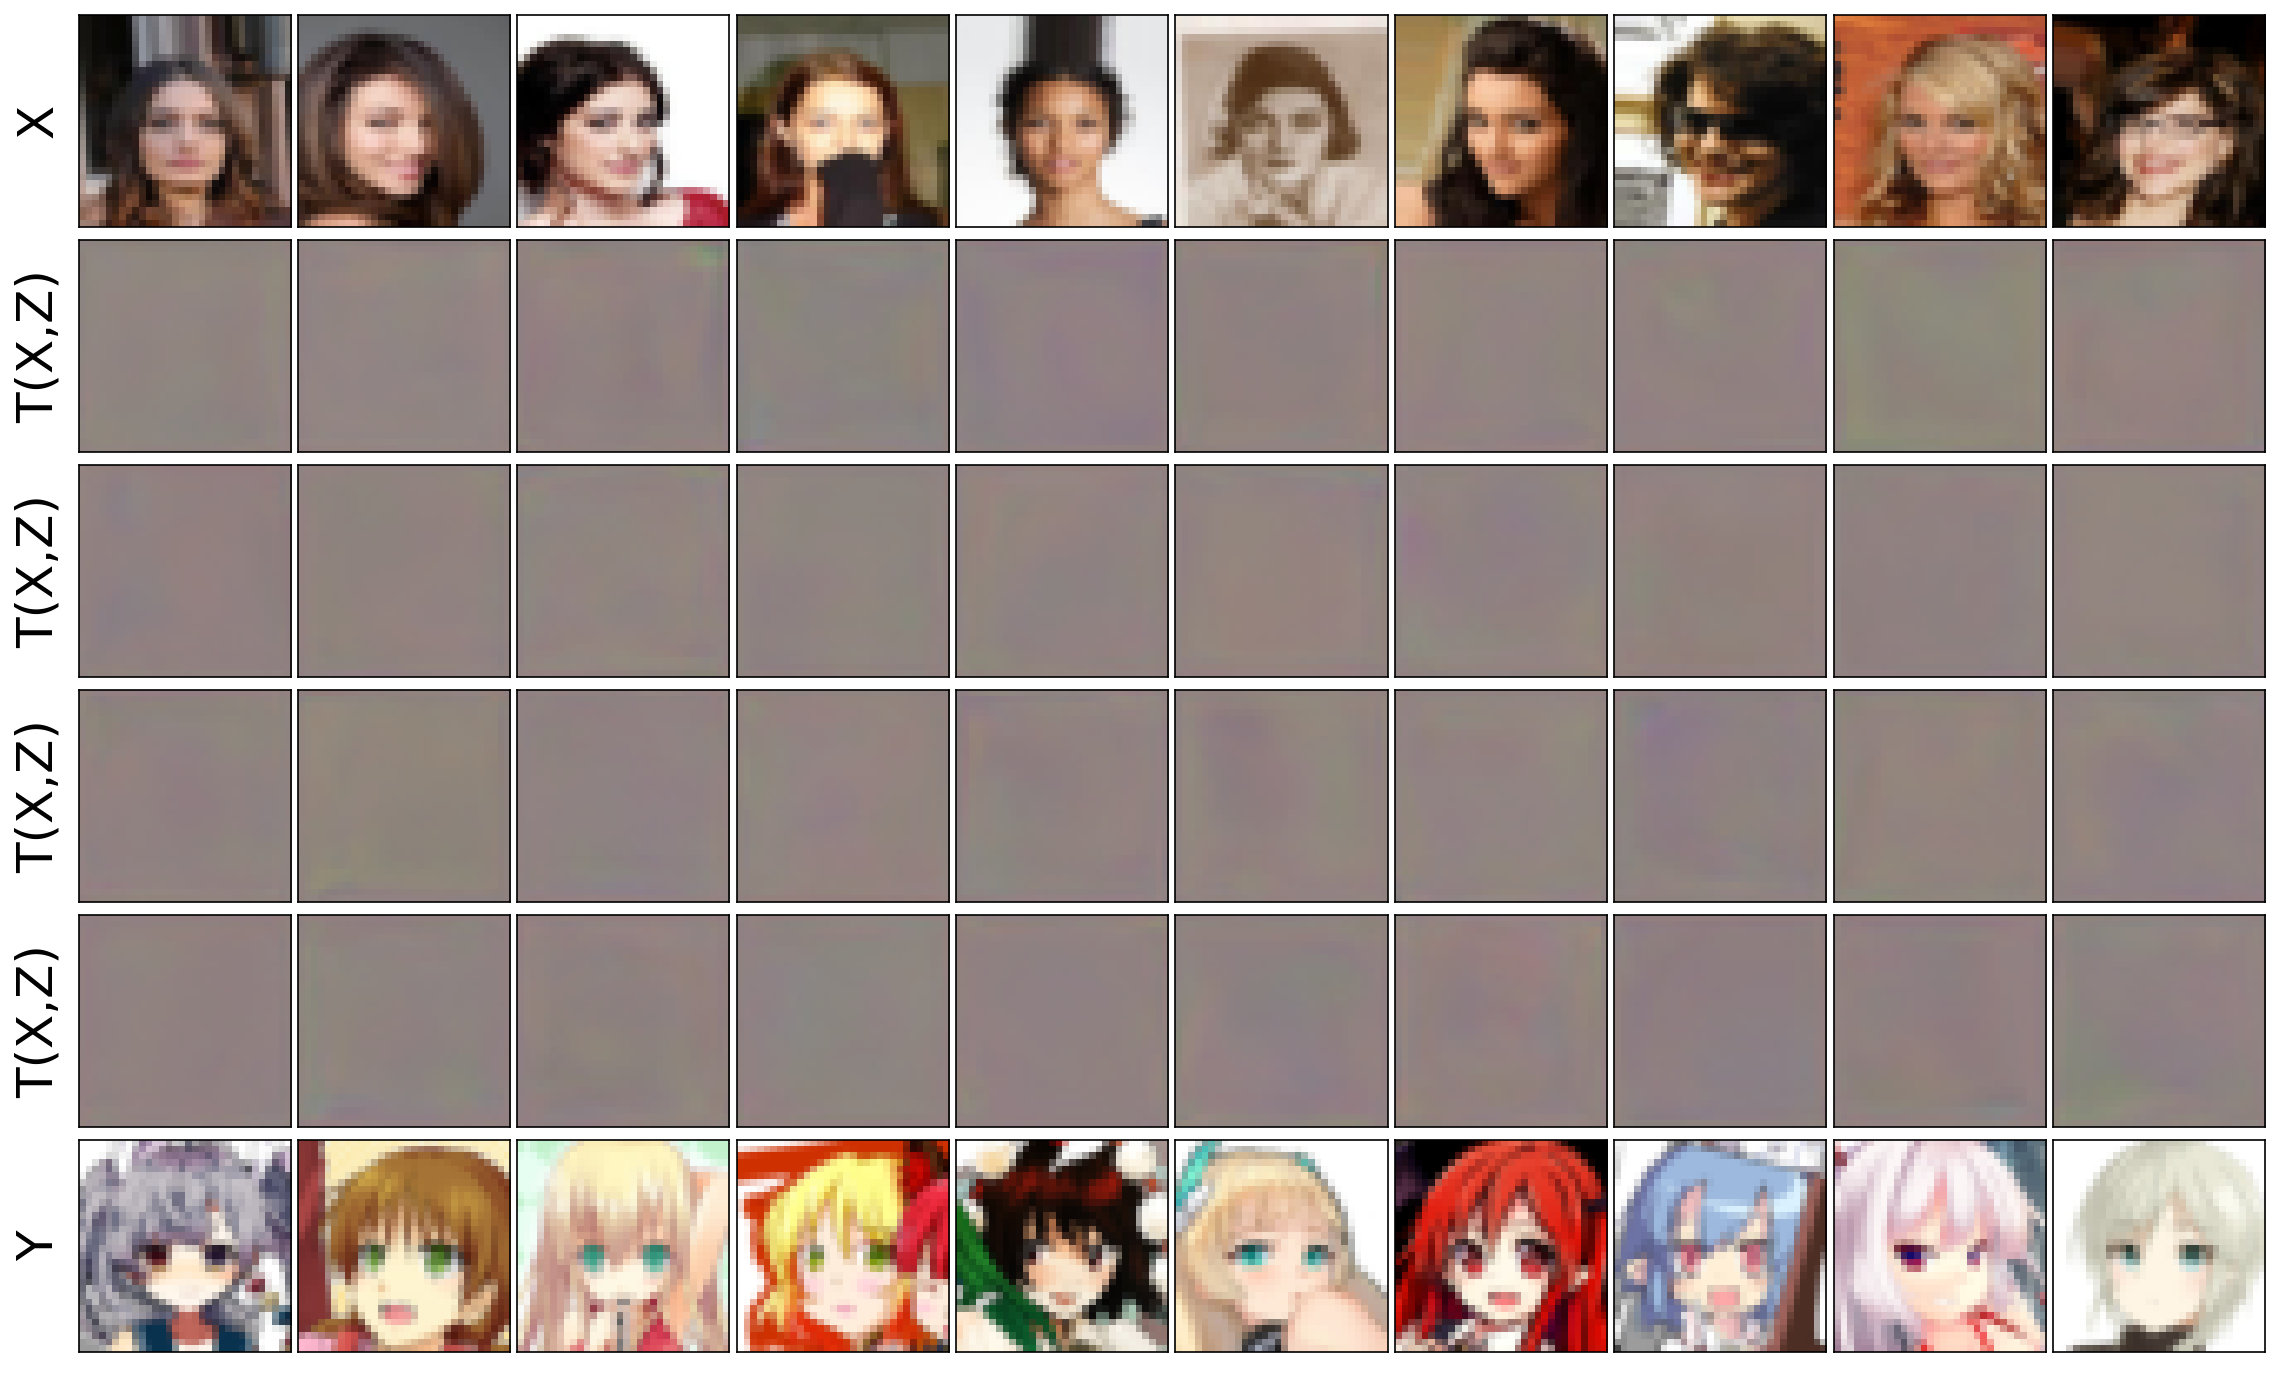

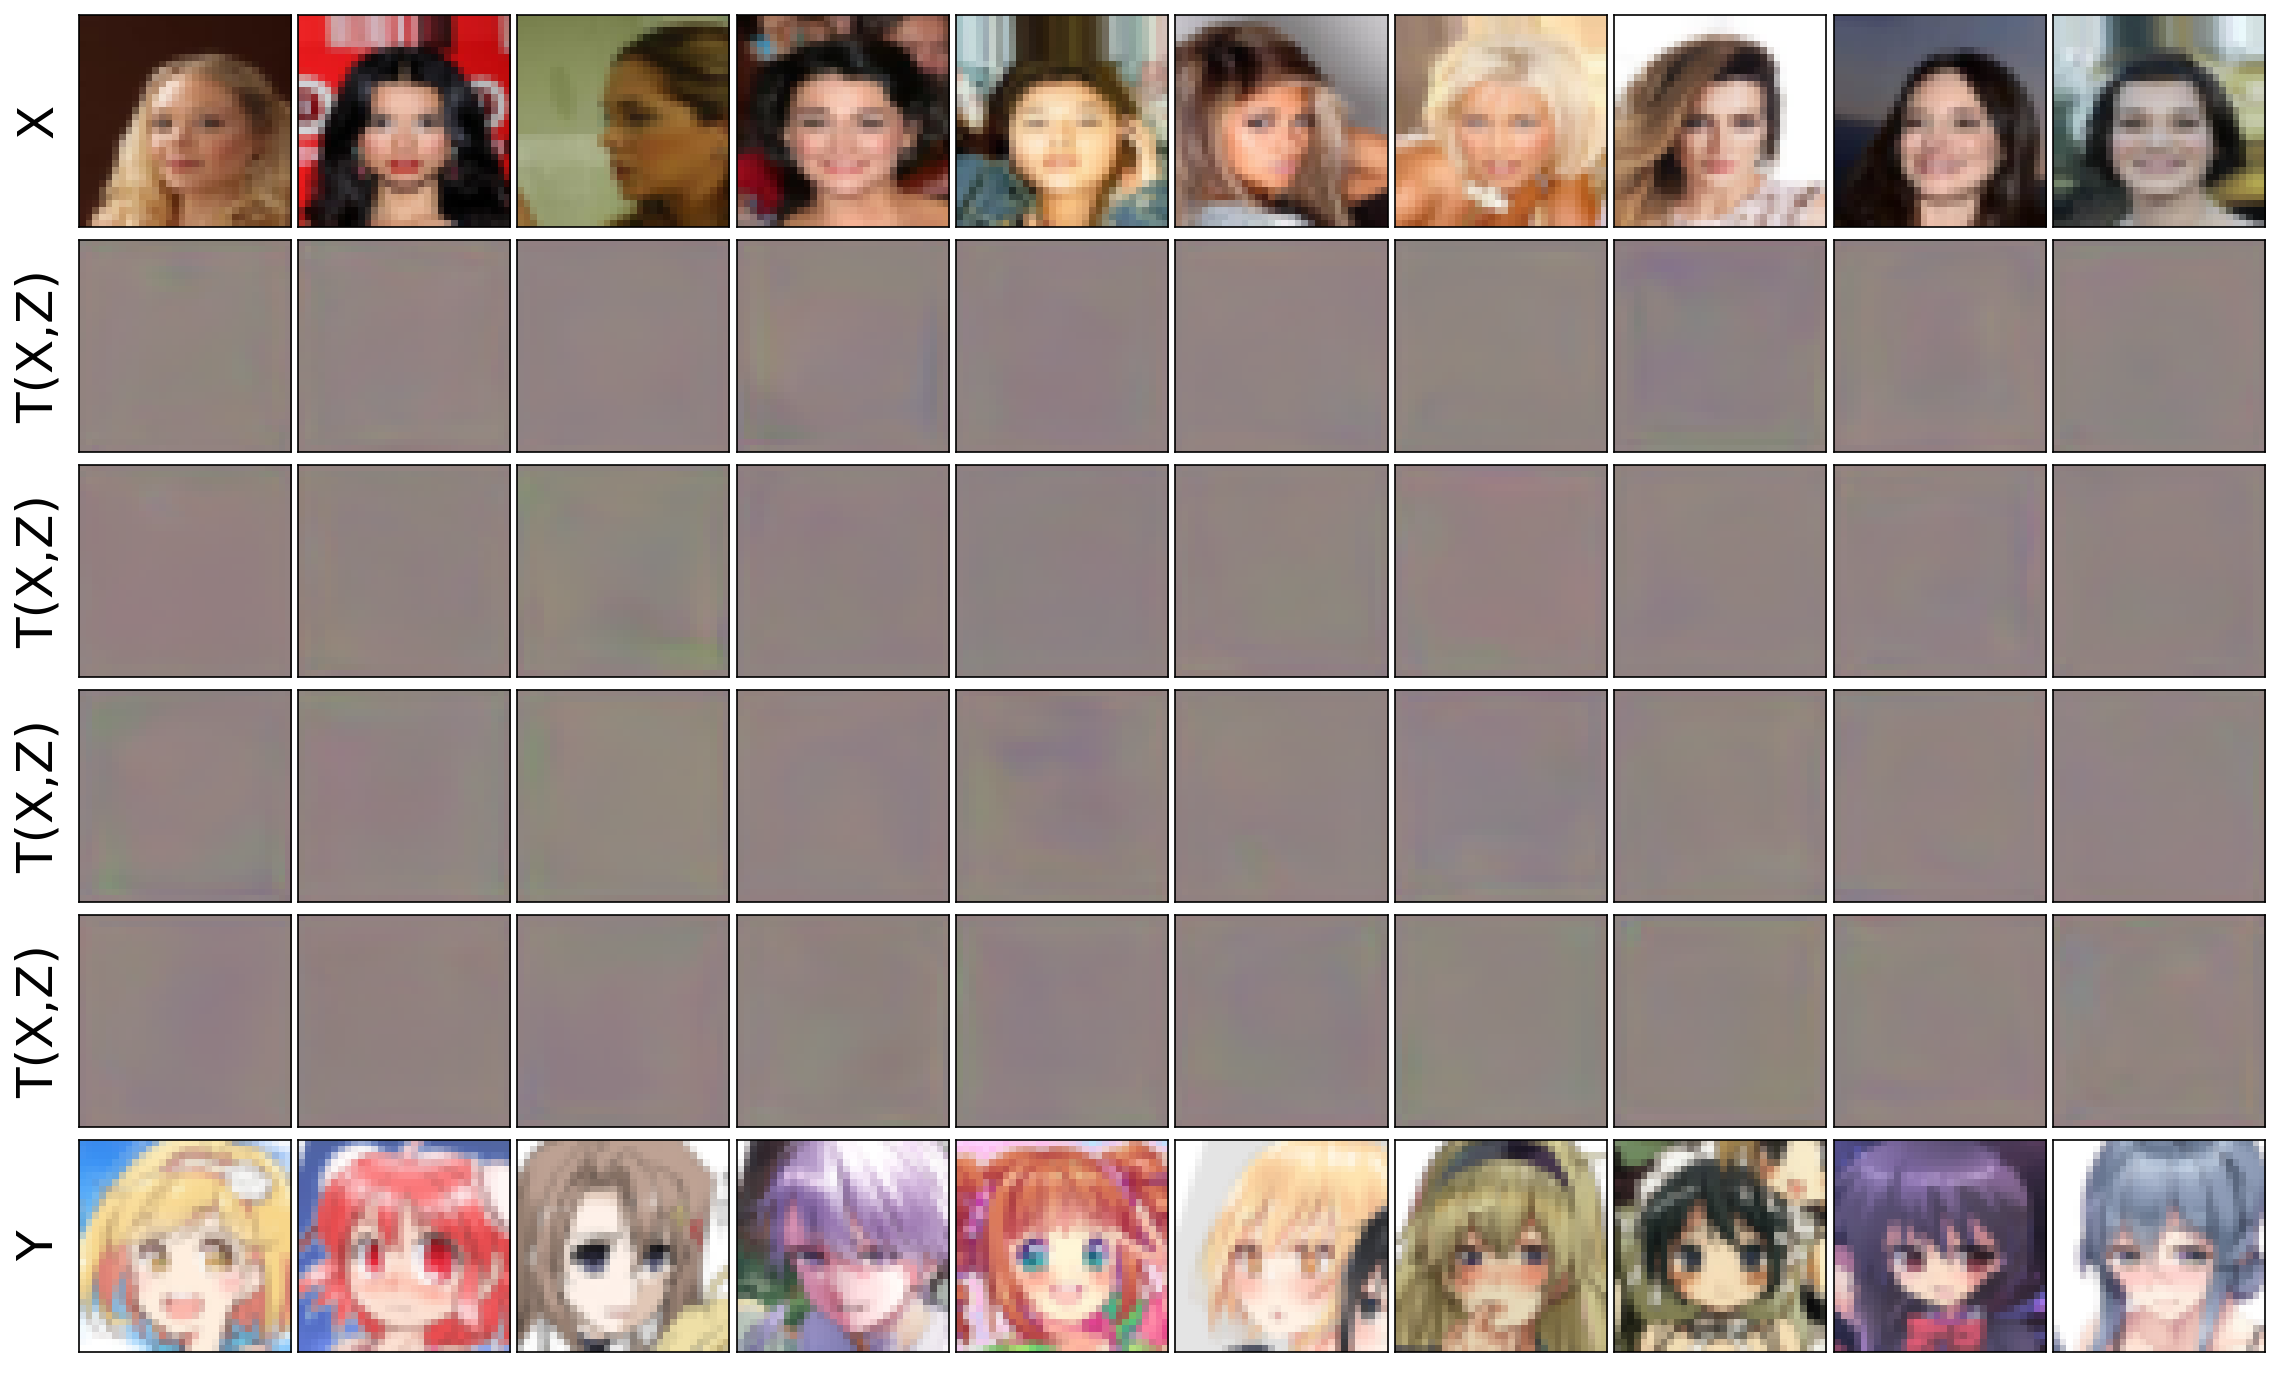

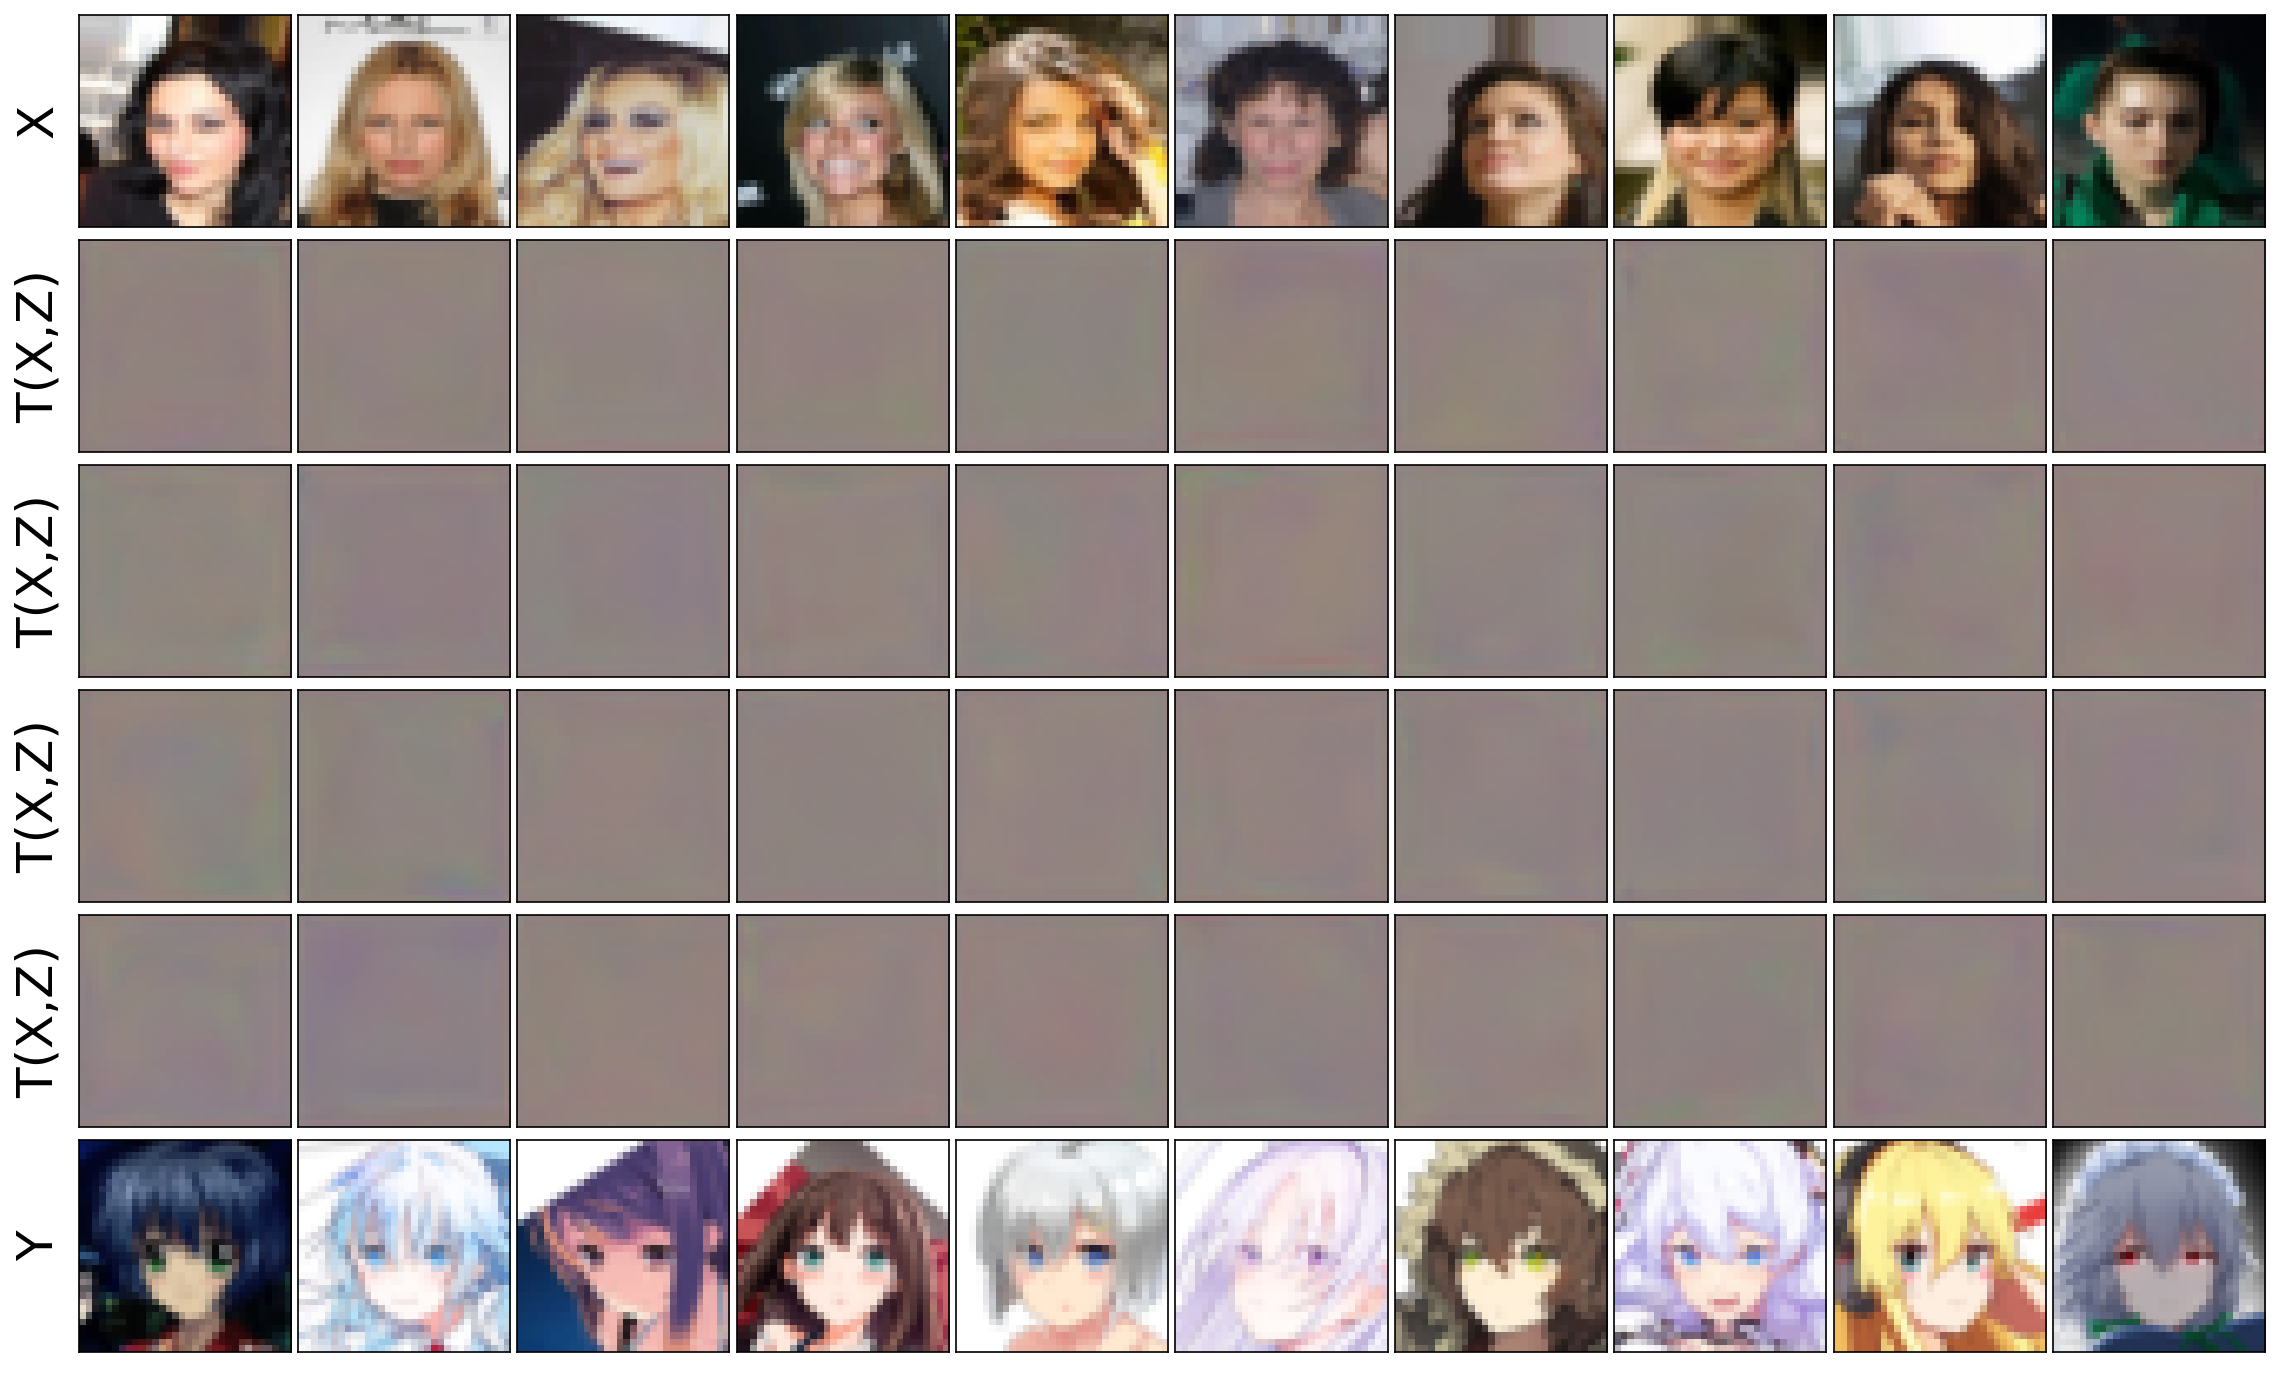

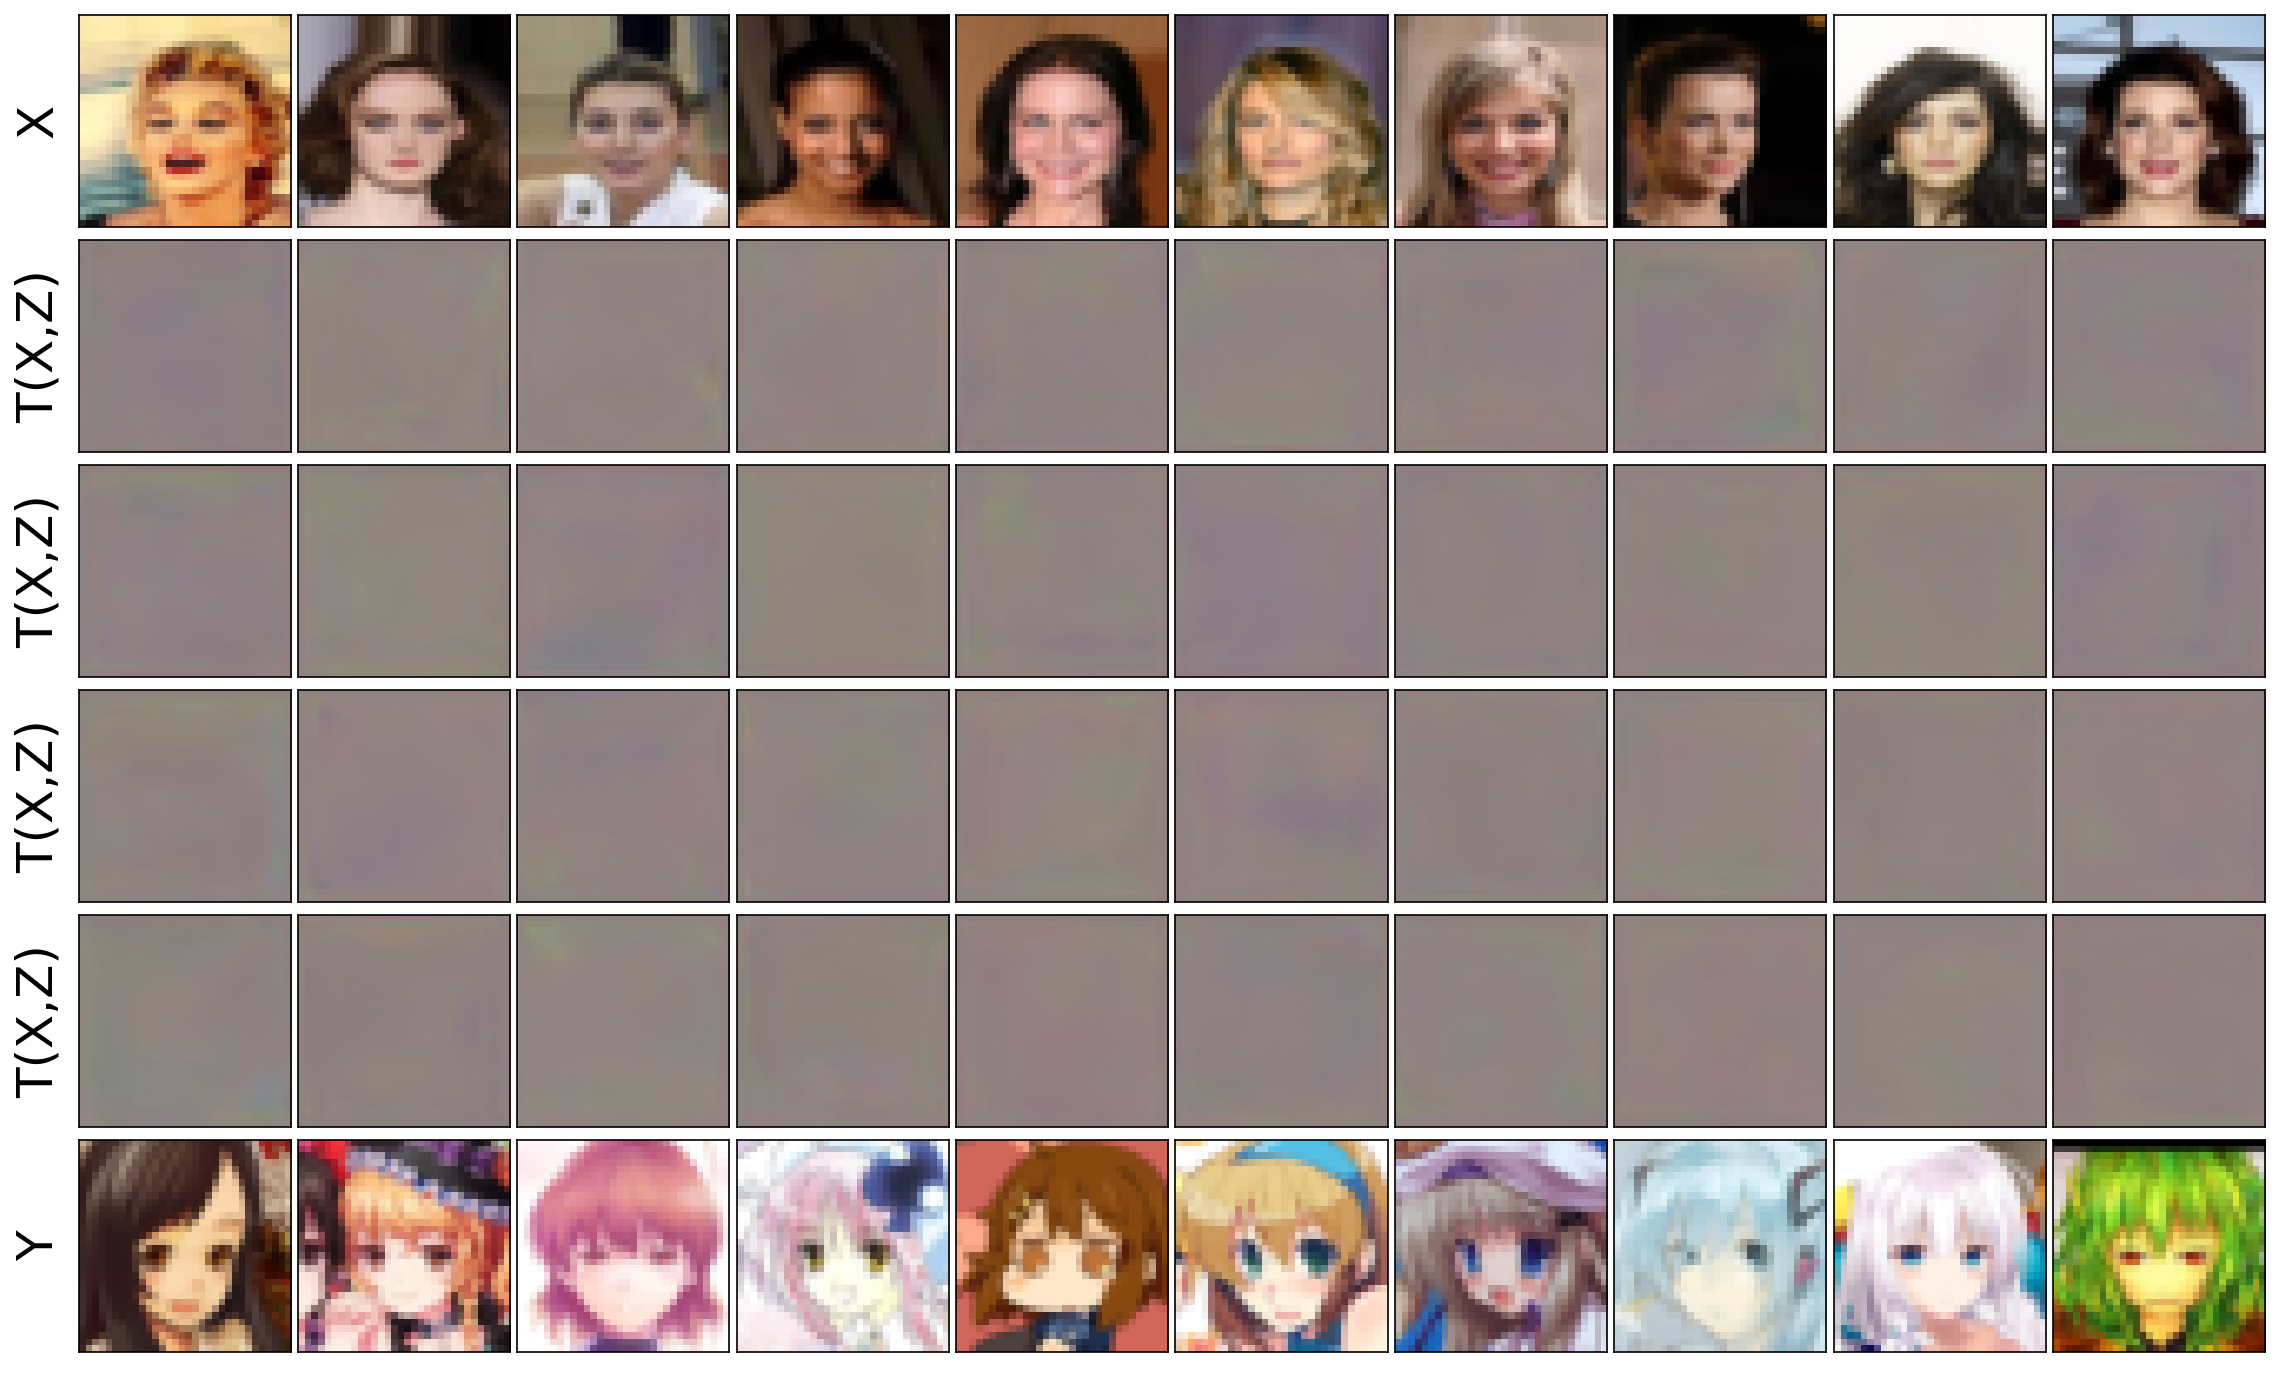

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.cunet import CUNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_Z_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.plotters import plot_random_Z_images, plot_Z_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin

from torch.utils.tensorboard import SummaryWriter

SEED = 5
DEVICE_IDS = [6, 7]

# DATASET2, DATASET2_PATH = 'handbag', '../../data/handbag_128.hdf5'
# DATASET1, DATASET1_PATH = 'shoes', '../../data/shoes_128.hdf5'
# DATASET2, DATASET2_PATH = 'handbag', '../../data/handbag_128.hdf5'

# DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
# DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

# DATASET1, DATASET1_PATH = 'outdoor', '../../data/outdoor_128.hdf5'
# DATASET2, DATASET2_PATH = 'church', '../../data/church_128.hdf5'

DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 32

ZC = 128
Z_STD = 1.

BATCH_SIZE = 64
Z_SIZE = 4

PLOT_INTERVAL = 500
COST = 'weak_mse' # 'laplacian' #'gaussian' #'weak_mse' # 
CPKT_INTERVAL = 2000
MAX_STEPS = 100001

GAMMA0, GAMMA1 = 0.0, 1.0
GAMMA_ITERS = 20000

CONTINUE = -1

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../my_checkpoints/{}/{}_{}_{}_seed_{}_gamma_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE, SEED, GAMMA1)

config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    D_LR=D_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)

FID_EPOCHS = 1
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
writer = SummaryWriter(os.path.join(OUTPUT_PATH, "tensorboard"))
path_to_save_fig = os.path.join(OUTPUT_PATH, "figs")
if not os.path.exists(path_to_save_fig):
    os.makedirs(path_to_save_fig)

path_to_save_models = os.path.join(OUTPUT_PATH, "models")
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)
    
filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()

D = ResNet_D(IMG_SIZE, nc=3).cuda()
D.apply(weights_init_D)
T = CUNet(3, 3, ZC, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    D = nn.DataParallel(D, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)
T_scheduler = torch.optim.lr_scheduler.MultiStepLR(T_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5)
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5)

if CONTINUE > -1:
    T_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{CONTINUE}.pt')))
    T_scheduler.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'T_scheduler_{SEED}_{CONTINUE}.pt')))
    T.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'T_{SEED}_{CONTINUE}.pt')))
    D_opt.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_opt_{SEED}_{CONTINUE}.pt')))
    D.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_{SEED}_{CONTINUE}.pt')))
    D_scheduler.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f'D_scheduler_{SEED}_{CONTINUE}.pt')))
    
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)
X_fixed = X_fixed[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_fixed = torch.randn(10, 4, ZC, 1, 1, device='cuda') * Z_STD
    XZ_fixed = (X_fixed, Z_fixed)
del X_fixed

X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)
X_test_fixed = X_test_fixed[:,None].repeat(1,4,1,1,1)
with torch.no_grad():
    Z_test_fixed = torch.randn(10, 4, ZC, 1, 1, device='cuda') * Z_STD
    XZ_test_fixed = (X_test_fixed, Z_test_fixed,)
del X_test_fixed

fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD, Y_sampler, T)
fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD, Y_test_sampler, T)

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)

best_fid = np.inf
best_step = 0

for step in tqdm(range(CONTINUE+1, MAX_STEPS)):
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)
    # T optimization
    unfreeze(T); freeze(D)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)[:,None].repeat(1,Z_SIZE,1,1,1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, 1, 1, device='cuda') * Z_STD
        T_XZ = T(
            X.flatten(start_dim=0, end_dim=1), Z.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3, IMG_SIZE, IMG_SIZE, -1, Z_SIZE).permute(3,4,0,1,2)
        
        if COST == 'weak_mse':
            # Weak quadratic cost (normalized by DIM)
            T_var = T_XZ.var(dim=1).mean()
            T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - \
            D(T_XZ.flatten(start_dim=0, end_dim=1)).mean() +  T_var * (1 - gamma - 1. / Z_SIZE)
        elif COST == 'energy':
            # Energy-based quadratic cost (for distance-induced kernel)
            T_var = .5 * torch.cdist(T_XZ.flatten(start_dim=2), T_XZ.flatten(start_dim=2)).mean() * Z_SIZE / (Z_SIZE -1)
            T_loss = (X-T_XZ).flatten(start_dim=2).norm(dim=2).mean() - \
            D(T_XZ.flatten(start_dim=0, end_dim=1)).mean() - gamma * T_var
        elif COST == 'gaussian':
            # Gaussian kernel (normalized by DIM)
            idx = torch.triu_indices(Z_SIZE, Z_SIZE, offset=1)
            T_var = 1 - torch.exp(
                -.5*(T_XZ[:,idx[0]]-T_XZ[:,idx[1]]).square().flatten(start_dim=2).mean(dim=2)
            ).mean()
            T_loss = 1 - torch.exp(-0.5 * (X-T_XZ).square().flatten(start_dim=2).mean(dim=2)).mean() -\
            D(T_XZ.flatten(start_dim=0, end_dim=1)).mean() - gamma * T_var
        elif COST == 'laplacian':
            # Laplacian kernel (normalized by DIM)
            idx = torch.triu_indices(Z_SIZE, Z_SIZE, offset=1)
            T_var = 1 - torch.exp(
                -(T_XZ[:,idx[0]]-T_XZ[:,idx[1]]).square().flatten(start_dim=2).mean(dim=2).sqrt()
            ).mean()
            T_loss = 1 - torch.exp(-(X-T_XZ).square().flatten(start_dim=2).mean(dim=2).sqrt()).mean() -\
            D(T_XZ.flatten(start_dim=0, end_dim=1)).mean() - gamma * T_var
        else:
            raise Exception("I do know know this cost!")
        
        T_loss.backward(); T_opt.step()
    T_scheduler.step()
    
    writer.add_scalar('var',
                      T_var.item(),
                      step + 1)
    
    # wandb.log({'var' : T_var.item()}, step=step)
    del T_loss, T_XZ, X, Z, T_var; gc.collect(); torch.cuda.empty_cache()

    # D optimization
    freeze(T); unfreeze(D)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, 1, 1, device='cuda') * Z_STD
        T_XZ = T(X,Z)
    Y = Y_sampler.sample(BATCH_SIZE)
    D_opt.zero_grad()
    D_loss = D(T_XZ).mean() - D(Y).mean()
    D_loss.backward(); D_opt.step(); D_scheduler.step()
    
    writer.add_scalar('D_loss',
                      D_loss.item(),
                      step + 1)
    
    # wandb.log({f'D_loss' : D_loss.item()}, step=step)
    del D_loss, Y, X, T_XZ, Z; gc.collect(); torch.cuda.empty_cache()
            
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_Z_images(XZ_fixed, Y_fixed, T)
        writer.add_figure('Fixed Images',
                          fig,
                          global_step=step + 1)
        # wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_sampler, ZC, Z_STD,  Y_sampler, T)
        writer.add_figure('Random Images',
                          fig,
                          global_step=step + 1)
        # wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_Z_images(XZ_test_fixed, Y_test_fixed, T)
        writer.add_figure('Fixed Test Images',
                          fig,
                          global_step=step + 1)
        # wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_Z_images(X_test_sampler, ZC, Z_STD,  Y_test_sampler, T)
        writer.add_figure('Random Test Images',
                          fig,
                          global_step=step + 1)
        # wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
    
    if step % CPKT_INTERVAL == 0:
        freeze(T)
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'T_{SEED}_{step}.pt'))
        torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D_{SEED}_{step}.pt'))
        torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'D_opt_{SEED}_{step}.pt'))
        torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
        torch.save(D_scheduler.state_dict(), os.path.join(OUTPUT_PATH, f'D_scheduler_{SEED}_{step}.pt'))
        torch.save(T_scheduler.state_dict(), os.path.join(OUTPUT_PATH, f'T_scheduler_{SEED}_{step}.pt'))
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(T, X_test_sampler.loader, ZC=ZC, Z_STD=Z_STD, n_epochs=FID_EPOCHS)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        writer.add_scalar('FID (Test)',
                          fid,
                          global_step=step + 1)
        # wandb.log({f'FID (Test)' : fid}, step=step)
        
        print(f"Current test FID = {fid}, best FID = {best_fid}, step = {step}, best step = {best_step}")
        if fid < best_fid:
            best_fid = fid
            best_step = step
            print(f"New best FID = {best_fid}, best step = {step}, ")
            freeze(T)
            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'best_T_{SEED}.pt'))
            torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'best_D_{SEED}.pt'))
            torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'best_D_opt_{SEED}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'best_T_opt_{SEED}.pt'))
            torch.save(D_scheduler.state_dict(), os.path.join(OUTPUT_PATH, f'best_D_scheduler_{SEED}.pt'))
            torch.save(T_scheduler.state_dict(), os.path.join(OUTPUT_PATH, f'best_T_scheduler_{SEED}.pt'))

        del mu, sigma
    
    gc.collect(); torch.cuda.empty_cache()

Plotting
